## Модели ARIMA и GARCH, прогнозирование значений на их основе

Выберите ряд из первого задания и постройте его модель ARIMA/GARCH. Отчет нужно будет оформить в jupyter-ноутбук.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [1]:
from scipy.stats import boxcox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
%matplotlib inline

In [3]:
auto_registration = pd.read_csv("homework_monthly-us-auto-registration-tho.csv",sep=';')

Посмотрим, как выглядят наш нестанционарный ряд:

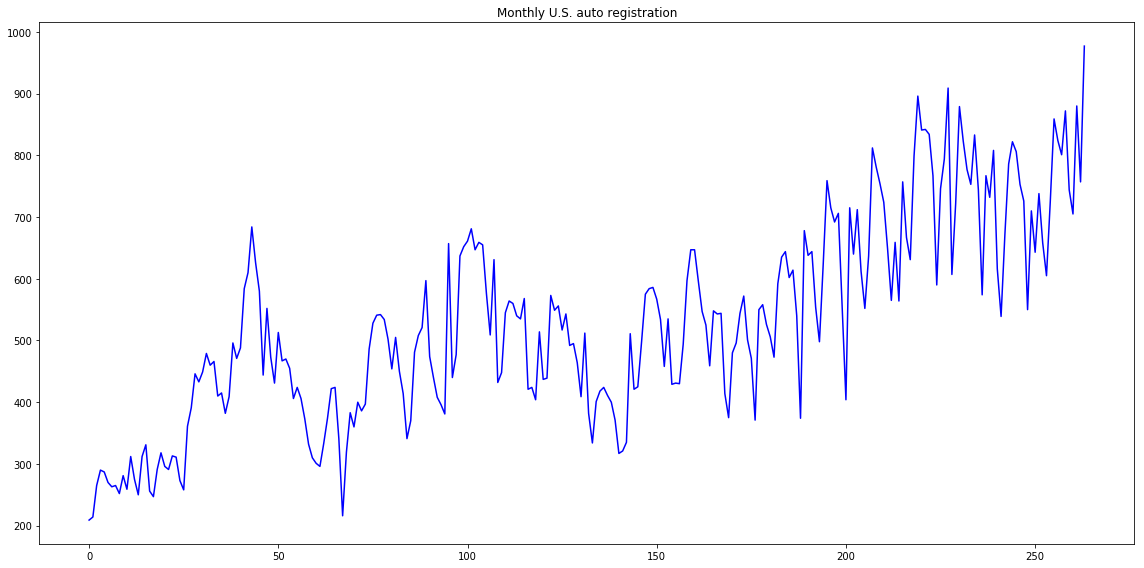

In [4]:
plt.figure(figsize=(16, 8))
layout = (3, 2)
ts_ax = plt.subplot()
auto_registration["Count"].plot(ax=ts_ax, color='blue')
ts_ax.set_title("Monthly U.S. auto registration")
plt.tight_layout()